The next material was taken from Kaggle, all the credits for them.

https://www.kaggle.com/learn/machine-learning-explainability

# Introduction

One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?

This concept is called **feature importance**.

There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

In this lesson, we'll focus on **permutation importance**. Compared to most other approaches, permutation importance is:

+ fast to calculate,
+ widely used and understood, and
+ consistent with properties we would want a feature importance measure to have.


# How It Works
Permutation importance uses models differently than anything you've seen so far, and many people find it confusing at first. So we'll start with an example to make it more concrete.

Consider data with the following format:

<img src="https://i.imgur.com/wjMAysV.png" />

We want to predict a person's height when they become 20 years old, using data that is available at age 10.

Our data includes useful features (height at age 10), features with little predictive power (socks owned), as well as some other features we won't focus on in this explanation.

**Permutation importance is calculated after a model has been fitted**. So we won't change the model or change what predictions we'd get for a given value of height, sock-count, etc.

Instead we will ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

<img src="https://i.imgur.com/h17tMUU.png" />

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions. In this case, shuffling height at age 10 would cause terrible predictions. If we shuffled socks owned instead, the resulting predictions wouldn't suffer nearly as much.

With this insight, the process is as follows:

1. Get a trained model.
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

# Code Example

Our example will use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game. Model-building isn't our current focus, so the cell below loads the data and builds a rudimentary model.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

In [3]:
my_model.

array([0.19070619, 0.07428247, 0.09406222, 0.07652855, 0.04311935,
       0.05235963, 0.05357478, 0.02647078, 0.05961648, 0.05126961,
       0.0588491 , 0.0591493 , 0.07023695, 0.05193423, 0.02918402,
       0.00042609, 0.00233228, 0.00589795])

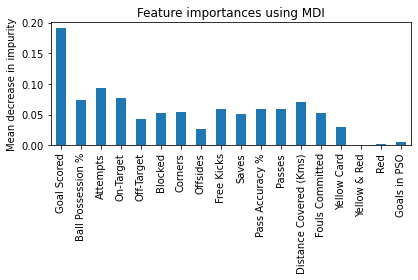

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(my_model.feature_importances_, index=feature_names)
std = np.std([
    my_model.feature_importances_ for tree in my_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Here is how to calculate and show importances with the eli5 library:

In [10]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


# Interpreting Permutation Importances

The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our example, the most important feature was **Goals scored**. That seems sensible. Soccer fans may have some intuition about whether the orderings of other variables are surprising or not.

# Excercise 

In [12]:
# Loading data, dividing, modeling and EDA below
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('taxi_fare_prediction/train.csv', nrows=50000)

# Remove data with extreme outlier coordinates or negative fares
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

y = data.fare_amount



In [13]:
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']

X = data[base_features]


In [14]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=50, random_state=1).fit(train_X, train_y)

print("Data sample:")
data.head()

Data sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1


In [15]:
train_X.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000
mean,-73.976827,40.756931,-73.975359,40.757434,1.662320
std,0.014625,0.018206,0.015930,0.018659,1.290729
min,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,-73.987964,40.744901,-73.987143,40.745756,1.000000
50%,-73.979628,40.758076,-73.978588,40.758542,1.000000
75%,-73.967797,40.769602,-73.966459,40.770406,2.000000
max,-73.900062,40.799952,-73.900062,40.799999,6.000000


In [16]:
train_y.describe()

count    23466.000000
mean         8.472539
std          4.609747
min          0.010000
25%          5.500000
50%          7.500000
75%         10.100000
max        165.000000
Name: fare_amount, dtype: float64

In [20]:
import seaborn as sns

# sns.displot(data=data, x_vars=[base_features])

C:\Users\Usuario\Anaconda3\envs\IA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

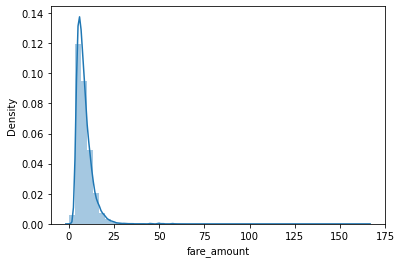

In [22]:
sns.distplot(data.fare_amount)

In [23]:
sns.scatterplot()

<function seaborn.relational.scatterplot(*, x=None, y=None, hue=None, style=None, size=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, x_bins=None, y_bins=None, units=None, estimator=None, ci=95, n_boot=1000, alpha=None, x_jitter=None, y_jitter=None, legend='auto', ax=None, **kwargs)>

In [24]:
base_features

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

<AxesSubplot:xlabel='passenger_count', ylabel='Count'>

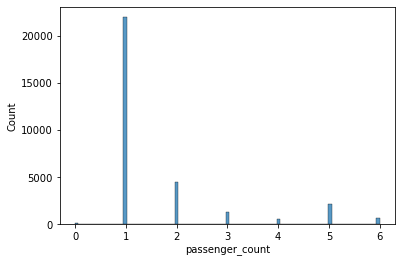

In [28]:
sns.histplot(data.passenger_count)

C:\Users\Usuario\Anaconda3\envs\IA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Usuario\Anaconda3\envs\IA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Usuario\Anaconda3\envs\IA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

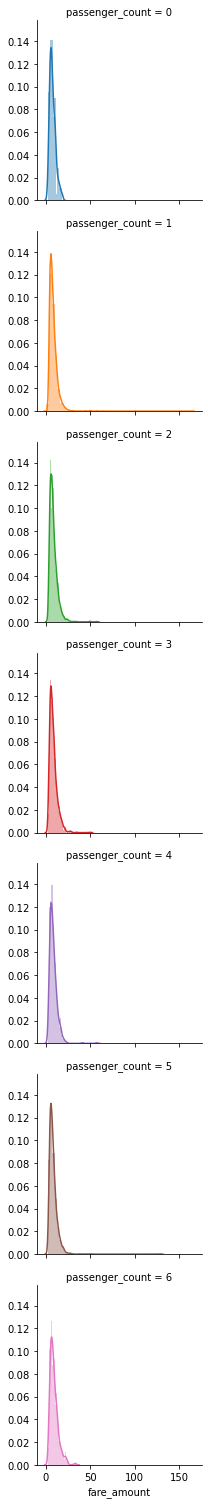

In [32]:
g = sns.FacetGrid(data, row="passenger_count", hue="passenger_count")

g.map(sns.distplot, "fare_amount")

In [35]:
import eli5
from eli5.sklearn import PermutationImportance

# Make a small change to the code below to use in this problem. 
perm = PermutationImportance(first_model, random_state=1).fit(val_X, val_y)


# uncomment the following line to visualize your results
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.8424 ± 0.0169,dropoff_latitude
0.8279 ± 0.0205,pickup_latitude
0.5939 ± 0.0437,pickup_longitude
0.5389 ± 0.0274,dropoff_longitude
-0.0021 ± 0.0013,passenger_count


1. Travel might tend to have greater latitude distances than longitude distances. If the longitudes values were generally closer together, shuffling them wouldn't matter as much. 2. Different parts of the city might have different pricing rules (e.g. price per mile), and pricing rules could vary more by latitude than longitude. 3. Tolls might be greater on roads going North<->South (changing latitude) than on roads going East <-> West (changing longitude). Thus latitude would have a larger effect on the prediction because it captures the amount of the tolls.

*Feature Engineering*

In [38]:
# create new features
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

# Create a PermutationImportance object on second_model and fit it to new_val_X and new_val_y
# Use a random_state of 1 for reproducible results that match the expected solution.
perm2 = PermutationImportance(second_model, random_state=1).fit(new_val_X, new_val_y)

# show the weights for the permutation importance you just calculated
eli5.show_weights(perm2, feature_names = new_val_X.columns.tolist())


Weight,Feature
0.5988 ± 0.0598,abs_lat_change
0.4484 ± 0.0505,abs_lon_change
0.0813 ± 0.0243,pickup_latitude
0.0767 ± 0.0123,dropoff_latitude
0.0712 ± 0.0101,pickup_longitude
0.0594 ± 0.0136,dropoff_longitude


In [43]:
data.loc[:,['abs_lon_change', 'abs_lat_change']].describe()

,abs_lon_change,abs_lat_change
count,31289.000000,31289.000000
mean,0.013039,0.014893
std,0.011644,0.012234
min,0.000000,0.000000
25%,0.004947,0.006038
50%,0.010049,0.011670
75%,0.017717,0.020497
max,0.094065,0.094655


A colleague observes that the values for abs_lon_change and abs_lat_change are pretty small (all values are between -0.1 and 0.1), whereas other variables have larger values. Do you think this could explain why those coordinates had larger permutation importance values in this case?

Consider an alternative where you created and used a feature that was 100X as large for these features, and used that larger feature for training and importance calculations. Would this change the outputted permutaiton importance values?

Why or why not?

After you have thought about your answer, either try this experiment or look up the answer in the cell below.

*answer*

The scale of features does not affect permutation importance per se. The only reason that rescaling a feature would affect PI is indirectly, if rescaling helped or hurt the ability of the particular learning method we're using to make use of that feature. That won't happen with tree based models, like the Random Forest used here. If you are familiar with Ridge Regression, you might be able to think of how that would be affected. That said, the absolute change features are have high importance because they capture total distance traveled, which is the primary determinant of taxi fares...It is not an artifact of the feature magnitude.